In [14]:
import pandas as pd
import os, shutil
import tensorflow as tf
import IPython.display as display
import numpy as np
import time
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix, classification_report
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

# Load in Images

The data directories are comprised of the file path strings, one for each train, test, and split. Within the file paths are two folders. One folder has normal chest xray photos (no pneumonia) and another folder has chest xrays of people with pneumonia.

In [7]:
datadir_train = 'C:/Users/Raizel/Desktop/Flatiron/phase1/Project4/PneumoniaClassification/chest_xray/train'
datadir_test = 'C:/Users/Raizel/Desktop/Flatiron/phase1/Project4/PneumoniaClassification/chest_xray/test'
datadir_validate = 'C:/Users/Raizel/Desktop/Flatiron/phase1/Project4/PneumoniaClassification/chest_xray/val'
categories = ['NORMAL', 'PNEUMONIA']

# Pneumonia Domain Knowledge

According to the MayoClinic, "Pneumonia is an infection that inflames the air sacs in one or both lungs." People with Pneumonia experience caouing, extreme phlegm, fever, difficulty breathing, and chills. Pneumonia, like many other illness, is very uncomfortable. Using neural networks modeling once can classify an image of a healthy lung compared to the image of a lung of a Pneumonia patient. This way the doctor can learn more about the disease to correctly classify patients as having Pneumonia or not having Pneumonia.

# Data Augmentation

In [8]:
data_train = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        datadir_train, 
        target_size=(256, 256), 
        batch_size = 600, 
        seed = 27,
        class_mode="binary") 

Found 5216 images belonging to 2 classes.


In [9]:
data_test = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        datadir_test, 
        target_size=(256, 256), 
        batch_size = 624, 
        seed = 27,
        class_mode="binary")

Found 624 images belonging to 2 classes.


In [10]:
data_val = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        datadir_validate, 
        target_size=(256, 256), 
        batch_size = 16, 
        seed = 12,
        class_mode="binary")

Found 16 images belonging to 2 classes.


# Images

In [11]:
train_images, train_labels = next(data_train)
test_images, test_labels = next(data_test)
val_images, val_labels = next(data_val)

In [12]:
X_train = np.array(train_images)
y_train = np.array(train_labels)

X_test = np.array(test_images)
y_test = np.array(test_labels)

X_val = np.array(val_images)
y_val = np.array(val_labels)

In [ ]:
#visualize images
%matplotlib inline
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (18,12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i])
    plt.title(categories[int(train_labels[i])], fontsize = 15)
plt.show()

Since Pneumonia is known to inflame both lungs, I predicted the cloudier images are from Pneumonia patients. https://www.radiologyinfo.org/en/info.cfm?pg=pneumonia says white spots in the lungs is how doctors find an infection from an chest x-ray. 

# Model One - Feedforward Neural Network

In [ ]:
num_classes = 1

# specifying the model structure
model = Sequential()

#matching shape sizes
print(y_train.shape)
print(X_train.shape)

# specify the first hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# specify the second layer
model.add(Dense(64))
model.add(Dropout(0.2))

# specify the output layer
model.add(Dense(num_classes, activation='sigmoid'))

# model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['acc', 'Recall', 'Precision'])

#history necessary for summary and evaluation
history = model.fit(X_train.flatten()[:len(y_train)], y_train,
                    batch_size= 1,
                    epochs=4,
                    verbose=1,
                    validation_data=(X_val.flatten()[:len(y_val)], y_val.flatten()))
score = model.evaluate(X_test.flatten()[:len(y_test)], y_test.flatten(), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
model.summary()

In [ ]:
results_train = model.evaluate(X_train.flatten()[:len(y_train)], y_train)
results_test = model.evaluate(X_test.flatten()[:len(y_test)], y_test.flatten())
print(results_train, results_test)

# Evaluation Metrics - Model One

In [ ]:
#confusion matrix
pred = cnn.predict(X_test)
cm = confusion_matrix(y_test, pred.round())
cm

In [ ]:
classification_report(y_test, pred.round())

In [ ]:
sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pn'], yticklabels = ['normal', 'pn'])

ex. brain surgeoun trying to move cancer - precsion - being conservative and not moving a lot of cells, just cancerous cells - recall - get rid of more cells assuming cancerous - not leaving positives behind

Precision = TP/TP+FP Recall = TP/TP+FN

advantages
- independent, observations don't imapact each other

disadvantages
- underfit ---> variance lower , rigid structure - very few parameters - simple model therefore less variance 

There are 75 true negatives (normal images), 371 true positives (pneumonia images), 159 false positives, and 19 false negatives.

- Precision = TP/TP+FP = ((371)/(371+159)) = .7
- Recall = TP/TP+FN  = ((371)/(371+19)) = .95

The recall is good and the percision is ok (could be a lot better) which means the model didn't precisely differentiate between the two.

# Model Two - CNN

In [ ]:
tic = time.time()
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3), padding = 'same')) #3 x 3 shape of filter, 64 convolutions
cnn2.add(layers.MaxPooling2D((2, 2),padding='same'))
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn2.add(layers.AveragePooling2D((2, 2),padding='same'))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dropout(.5))
cnn2.add(layers.Dense(1, activation='sigmoid')) #sigmoid bc classification problem

cnn2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.002),
              metrics=['acc', 'Recall', 'Precision', 'AUC'])

history = cnn2.fit(X_train,
                y_train,
                epochs=5,
                batch_size=25,
                validation_data=(X_val, y_val))
toc = time.time()
print('run time:', toc-tic)

In [ ]:
cnn2.summary()

In [ ]:
results_train = cnn2.evaluate(data_train)
results_test = cnn2.evaluate(data_test)
print(results_train, results_test)

## Evaluation Metrics - Model Two

In [ ]:
#confusion matrix
pred2 = cnn2.predict(X_test)
cm = confusion_matrix(y_test, pred2.round())

In [ ]:
classification_report(y_test, pred2.round())

In [ ]:
sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pn'], yticklabels = ['normal', 'pn'])

# Model Three - CNN

In [ ]:
cnn3 = models.Sequential()
cnn3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3), padding = 'same')) #3 x 3 shape of filter, 64 convolutions
cnn3.add(layers.MaxPooling2D((2, 2),padding='same')) #padding added so edge pixels get included in convolution
cnn3.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same')) #hidden layer
cnn3.add(layers.MaxPooling2D((2, 2),padding='same')) #max pooling
cnn3.add(layers.Flatten()) #flatten layer
cnn3.add(layers.Dense(32, activation='relu'))
cnn3.add(layers.Dense(1, activation='sigmoid')) #sigmoid bc classification problem

cnn.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.007),
              metrics=['acc', 'Recall', 'Precision']) #compiling with gradient descent

history = cnn3.fit(X_train,
                y_train,
                epochs=5,
                batch_size=25,
                validation_data=(X_val, y_val))

In [ ]:
cnn3.summary()

In [ ]:
results_train = cnn3.evaluate(data_train)
results_test = cnn3.evaluate(data_test)
print(results_train, results_test)

## Evaluation Metrics - Model 3

In [ ]:
#confusion matrix
pred = cnn3.predict(X_test)
cm = confusion_matrix(y_test, pred.round())
cm

In [ ]:
plot_confusion_matrix(y_test, pred.round())

In [ ]:
classification_report(y_test, pred.round())

In [ ]:
sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pn'], yticklabels = ['normal', 'pn'])

# Model 4 - CNN

In [15]:
tic = time.time()
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,  3), padding = 'same',strides=2)) #3 x 3 shape of filter, 64 convolutions
cnn4.add(layers.AveragePooling2D((2, 2),padding='same',strides=2))
cnn4.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same',strides=2))
cnn4.add(layers.AveragePooling2D((2, 2),padding='same',strides=2))
cnn4.add(layers.Flatten())
cnn4.add(layers.Dense(32, activation='relu'))
cnn4.add(layers.Dense(1, activation='sigmoid')) #sigmoid bc classification problem

cnn4.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.002),
              metrics=['acc', 'Recall', 'Precision'])

In [16]:
history = cnn4.fit(X_train,
                    y_train,
                    epochs=9,
                    batch_size=25,
                    validation_data=(X_val, y_val))
toc = time.time()
print('run time:', toc-tic)

Epoch 1/9
24/24 [==============================] - 10s 313ms/step - loss: 0.6186 - acc: 0.7349 - recall: 0.9917 - precision: 0.7376 - val_loss: 0.6469 - val_acc: 0.7500 - val_recall: 0.8750 - val_precision: 0.7000
Epoch 2/9
24/24 [==============================] - 8s 334ms/step - loss: 0.5127 - acc: 0.7582 - recall: 0.9551 - precision: 0.7675 - val_loss: 0.7135 - val_acc: 0.7500 - val_recall: 1.0000 - val_precision: 0.6667
Epoch 3/9
24/24 [==============================] - 9s 360ms/step - loss: 0.3435 - acc: 0.8473 - recall: 0.9189 - precision: 0.8753 - val_loss: 0.9642 - val_acc: 0.6875 - val_recall: 1.0000 - val_precision: 0.6154
Epoch 4/9
24/24 [==============================] - 9s 356ms/step - loss: 0.2159 - acc: 0.9146 - recall: 0.9522 - precision: 0.9359 - val_loss: 0.4847 - val_acc: 0.8750 - val_recall: 1.0000 - val_precision: 0.8000
Epoch 5/9
24/24 [==============================] - 9s 380ms/step - loss: 0.2297 - acc: 0.9268 - recall: 0.9510 - precision: 0.9523 - val_loss: 0.34

In [17]:
cnn4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                262176    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [18]:
results_train = cnn4.evaluate(data_train)
results_test = cnn4.evaluate(data_test)
print(results_train, results_test)

1/1 [==============================] - 15s 15s/step - loss: 0.6351 - acc: 0.7917 - recall: 0.9718 - precision: 0.7610
[0.13622213900089264, 0.949769914150238, 0.9548386931419373, 0.977026641368866] [0.6350787281990051, 0.7916666865348816, 0.971794843673706, 0.7610442042350769]


## Evaluation Metrics - Model 4 

In [19]:
pred4 = cnn4.predict(X_test)
cm = confusion_matrix(y_test, pred4.round())
cm

array([[115, 119],
       [ 11, 379]], dtype=int64)

In [20]:
classification_report(y_test, pred4.round())

'              precision    recall  f1-score   support\n\n         0.0       0.91      0.49      0.64       234\n         1.0       0.76      0.97      0.85       390\n\n    accuracy                           0.79       624\n   macro avg       0.84      0.73      0.75       624\nweighted avg       0.82      0.79      0.77       624\n'

<AxesSubplot:>

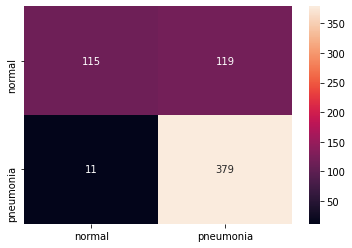

In [22]:
sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pneumonia'], yticklabels = ['normal', 'pneumonia'])

# Model 5 - InceptionV3

In [ ]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False)
imagenet_new=imagenet.output
inception_model = models.Sequential()
inception_model.add(imagenet)
inception_model.add(GlobalAveragePooling2D())
inception_model.add(Dense(1024,activation='relu'))
inception_model.add(Dense(1024,activation='relu')) #dense layer 2
inception_model.add(Dense(512,activation='relu')) #dense layer 3
inception_model.add(Dense(1,activation='sigmoid')) #final layer with sigmoid activation

In [ ]:
inception_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

inception_model.fit(data_train,
          epochs=6,
          batch_size=32,
          validation_data=(data_val))

In [ ]:
inception_model.evaluate(X_train)

In [ ]:
predictions_transfer = inception_model.predict(X_test)
predictions_transfer = np.around(predictions_transfer)

## Evaluation Metrics - Model 5

In [ ]:
#confusion matrix
pred5 = inception_model.predict(X_test)
cm = confusion_matrix(y_test, pred5.round())
cm

In [ ]:
classification_report(y_test, pred5.round())

In [ ]:
sns.heatmap(cm, annot=True, fmt='g', xticklabels = ['normal', 'pn'], yticklabels = ['normal', 'pn'])

# Summary/Business Recommendation

# Futher Steps and Analysis